# 🛒 **Online Grocery Store Chatbot**

This project is an online grocery store chatbot based on **LangGraph** and **Gemini 2.0 Flash**.

Users can find products and add them to their cart by **making natural language requests** to the chatbot, without having to navigate categories or search for products directly.

## ✅ **Key Features**

- Browse product categories

- Search for specific products or brands

- Compare based on price, rating, reviews

- Add to cart / modify / check cart

## 💡 **Usage Scenario Examples**

> "show me milk under $5"

> "compare popcorn brands by rating"

> "what's in my cart?"

How exactly does this chatbot understand user requests and build a shopping cart?   
This notebook walks through the entire process step by step, using visual aids.

# 📍 **Step 1. LangGraph Structure Visualization + Tool Introduction**

## 📸 **1-1. Display Structure Image**

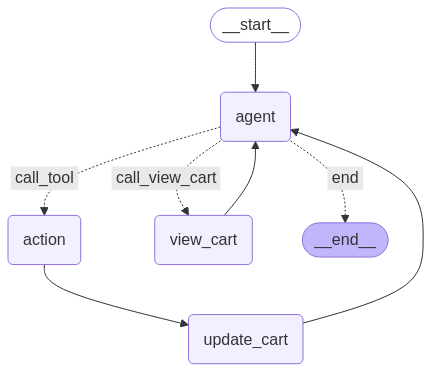

In [1]:
from IPython.display import Image, display

# Graph visualization image file path
display(Image(filename="./assets/graph_image.png", width=450))

## ⚙️ **1-2. LangGraph Structure Explanation**

This chatbot processes user requests through the following steps using LangGraph:

1. **Agent Node**

   - The LLM receives the user's request and determines what actions (tool calls, etc.) are needed.

2. **Tool Node**

   - Calls the appropriate tool to perform actual product searches, comparisons, cart manipulations, etc.

3. **Update Cart Node**

   - Updates the cart status based on the tool's results.

4. **View Cart Node (Separate Processing)**

   - When checking the cart, it branches separately to view it.

### 🔧 **Available Main Tool Types**

| Category | Tool Name (Example Function) | Description | Example Query |
|------|-----------|------|------|
| 🧺 **Category Exploration** | `search_category_by_type` | Search by category name | "do you have vegetables?" |
|                      | `search_category_by_type_all` | List all categories | "what kinds of categories do you have?" |
| 🧂 **Product Exploration** | `search_ingredient_by_brand` | Search by brand or product name | "show me Apple juice" |
|                     | `search_multiple_ingredients` | Find multiple products simultaneously | "show me popcorn and milk" |
|                     | `search_ingredient_by_price` | Search by price criteria | "find milk under $3" |
|                     | `search_ingredient_by_rating` | Search for highly rated products | "best rated popcorn" |
| 🔍 **Product Comparison** | `compare_ingredient_by_price` | Compare brands by price | "compare milk brands by price" |
|                   | `compare_ingredient_by_rating` | Compare by rating | "which popcorn is best rated?" |
| 🛒 **Cart Manipulation** | `add_to_cart`, `remove_from_cart`, etc. | Cart management | "add 2 oat milks to cart" |
| 🤖 **Others** | `greeting`, `help`, `fallback` | Handle greetings/help/incorrect requests | "hi", "help", "tell me a joke" |

# 📘 **Step 2. Environment Setup and Data Load**

## 🧱 **2-1. Environment Setup**

In [2]:
# Model Configuration
MODEL_NAME = "gemini-2.0-flash"
TEMPERATURE = 0.73

# Data Path
DATA_FILE_PATH = "./data/sample_data.csv"  # "/kaggle/input/online-grocery-store-chatbot-data/sample_data.csv"

# Fuzzy Matching Configuration
FUZZY_SCORE_THRESHOLD = 67  # threshold

In [3]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)


print("📁 Data path:", DATA_FILE_PATH)
print("🧠 Fuzzy Matching threshold:", FUZZY_SCORE_THRESHOLD)

📁 Data path: ./data/sample_data.csv
🧠 Fuzzy Matching threshold: 67


## 🧪 **2-2. Data Load + Preview**

In [4]:
import pandas as pd

try:
    data = pd.read_csv(DATA_FILE_PATH)
    print(f"✅ Data loaded successfully! Total {len(data)} items")
except FileNotFoundError:
    print(f"❌ Data file not found: {DATA_FILE_PATH}")
    data = pd.DataFrame()

# Check a portion of the data
data.head()

✅ Data loaded successfully! Total 120 items


,category_type,product_type,product_brand,product_rating,product_review,product_price
0,Vegetables,Carrot,FreshFarm,4.5,150,2.99
1,Vegetables,Carrot,Nature's Best,4.6,120,3.19
2,Vegetables,Carrot,VeggieWorld,4.4,100,2.79
3,Vegetables,Carrot,GreenLeaf,4.7,90,3.09
4,Vegetables,Carrot,FarmSelect,4.3,80,2.89


## **🧾 2-3. Extract Available Categories**

In [5]:
# ✅ Extract available categories
available_categories = (
    data["category_type"].astype(str).str.strip().str.lower().unique().tolist()
)

print("📦 List of available categories:")
for i, cat in enumerate(available_categories, 1):
    print(f"{i}. {cat}")

📦 List of available categories:
1. vegetables
2. fruits
3. meats
4. dairy
5. bakery
6. beverages
7. snacks
8. frozen foods


# 📘 **Step 3. Exploring User-Friendly Features**

## 💡 **3-1. Fuzzy Matching (Similar Word Matching)**

In [6]:
from thefuzz import process


def find_closest_category(
    query: str, categories: list[str], threshold: int = 67
) -> dict:
    query = query.strip().lower()
    best_match, score = process.extractOne(query, categories)
    if score >= threshold:
        return {
            "status": "matched",
            "input": query,
            "matched_category": best_match,
            "score": score,
        }
    else:
        return {
            "status": "not_matched",
            "input": query,
            "suggestion": best_match,
            "score": score,
        }


# Test example inputs
test_inputs = ["veggie", "Veggies", "dairy", "frut", "snakz"]

for query in test_inputs:
    print(find_closest_category(query, available_categories))

{'status': 'matched', 'input': 'veggie', 'matched_category': 'vegetables', 'score': 72}
{'status': 'not_matched', 'input': 'veggies', 'suggestion': 'beverages', 'score': 62}
{'status': 'matched', 'input': 'dairy', 'matched_category': 'dairy', 'score': 100}
{'status': 'matched', 'input': 'frut', 'matched_category': 'fruits', 'score': 80}
{'status': 'matched', 'input': 'snakz', 'matched_category': 'snacks', 'score': 73}


### **✨ Fuzzy Matching**

- Even if the user doesn't enter "vegetables" exactly, the system can find it when they request "veggie" or "veggies".

- This is implemented using the `extractOne()` function from the `thefuzz` library.

## 💵 **3-2. Price Filter Example (Hands-on Experience)**

In [7]:
# 💰 Filter by price condition for a specific product
def search_product_under_price(data, product_type: str, max_price: float):
    filtered = data[
        (data["product_type"].str.lower() == product_type.lower())
        & (data["product_price"].astype(float) <= max_price)
    ]
    return filtered[["product_brand", "product_price"]].sort_values(by="product_price")


# Example: milk products under $5
search_product_under_price(data, "milk", 5.0)

,product_brand,product_price
49,YogurtLand,3.99
48,CheeseCraft,4.09
47,CreamyGold,4.19
45,DairyPure,4.29
46,PureDairy,4.39


### **💵 Price-Based Filtering**

 - When a user inputs `"show me milk under $5"`,<br>the system finds items of that product type where `product_price <= 5` and sorts them to display.

## 🧁 **3-3. Finding Products with High Review Count or Rating (Hands-on Experience)**

In [8]:
# 🌟 Example of finding highly rated products
def find_high_rated_products(data, product_type: str, min_rating: float = 4.0):
    df = data[data["product_type"].str.lower() == product_type.lower()]
    filtered = df[df["product_rating"].astype(float) >= min_rating]
    return filtered[["product_brand", "product_rating"]].sort_values(
        by="product_rating", ascending=False
    )


# Example: popcorn with rating 4.5 or higher
find_high_rated_products(data, "popcorn", 4.5)

,product_brand,product_rating
101,SweetBite,4.5


## 🧪 **Warm-Up Summary**

In this part, we've experienced how the chatbot processes **human-centered natural language requests**.

- "veggie" → automatically matched to "vegetables"

- "milk under $5" → condition filtering

- "best popcorn" → rating-based filtering

👉 In the next part, we'll visually examine how these features flow within LangGraph.

# 📘 **Step 4. Exploring LangGraph Structure**

## 🧠 **4-1. Overall Structure Graph Visualization**

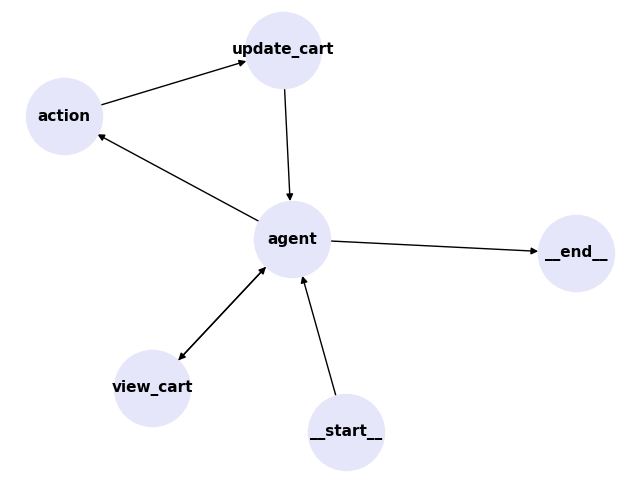

In [9]:
# 🧭 LangGraph node/edge visualization
import networkx as nx
import matplotlib.pyplot as plt

# Graph configuration
G = nx.DiGraph()

G.add_edges_from(
    [
        ("__start__", "agent"),
        ("agent", "action"),  # call_tool -> action
        ("action", "update_cart"),
        ("update_cart", "agent"),
        ("agent", "view_cart"),  # call_view_cart -> view_cart
        ("view_cart", "agent"),
        ("agent", "__end__"),  # end
    ]
)

# Visualization
plt.figure(figsize=(8, 6), facecolor="white")
pos = nx.spring_layout(G, seed=2)
nx.draw_networkx(
    G,
    pos,
    node_size=3000,
    node_color="lavender",
    font_size=11,
    font_weight="bold",
)
plt.axis("off")
plt.show()

## 🧾 **4-2. Summary of Each Node's Role**

| Node Name | Description |
|-----------|------|
| `agent` | LLM analyzes user messages to determine appropriate tool calls |
| `action` | Node that executes actual tools (`ToolNode`) |
| `update_cart` | Updates cart status based on tool execution results |
| `view_cart` | Displays the cart content using the current state |
| `__start__` | Starting point of the graph |
| `__end__` | Conversation end point |

## 💡 **4-3. Flow Example Explanation**

Example: When a user says "add 2 milks of A brand to cart":

1. User requests "add 2 milks of A brand to cart"

2. `agent` → determines `call_tool` → executes `add_to_cart` in `action` node

3. Reflects in the cart at `update_cart`

4. Returns to `agent` to wait for the next request

Example: When a user says "what's in my cart?":

1. User requests "what's in my cart?"

2. `agent` → determines `call_view_cart`

3. Returns cart from `view_cart`

4. Returns to `agent` to wait for the next request

## 🔁 **4-4. Understanding State Structure**

Shows what structure the state values passed to the graph have. (example)

In [10]:
# 예시 초기 상태
exp_state = {
    "messages": [],
    "category_type": None,
    "product_type": None,
    "product_brand": None,
    "product_rating": None,
    "product_review": None,
    "product_price": None,
    "cart_items": [],
    "finished": False,
}

# 구조 확인
exp_state

{'messages': [],
 'category_type': None,
 'product_type': None,
 'product_brand': None,
 'product_rating': None,
 'product_review': None,
 'product_price': None,
 'cart_items': [],
 'finished': False}

## 🧪 **Warm-Up Summary**

LangGraph clearly visualizes the conversation flow and allows control over the reasoning flow.

- Each step is composed of clearly separated nodes

- Flow control and state updates are simple and clear

- As functionality becomes more complex, **LangGraph structure provides powerful advantages in readability and maintenance**

👉 Now we're ready to run the actual code and have a direct conversation with the chatbot!

 # 📘 **Step 5. Execution Code Setup**

 ## ✅ **5-1. State Definition**

In [11]:
from typing import TypedDict, Annotated, List, Optional, Dict, Any

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


# Define the state for the chatbot
class State(TypedDict):
    # Message storage
    messages: Annotated[List[BaseMessage], add_messages]

    # Current product information
    category_type: Optional[str]  # Product category
    product_type: Optional[str]  # Product type
    product_brand: Optional[str]  # Product brand
    product_rating: Optional[float]  # Product rating
    product_review: Optional[int]  # Number of product reviews
    product_price: Optional[float]  # Product price

    # Shopping cart
    cart_items: List[Dict[str, Any]]  # List of items in the cart

    # Transaction status
    finished: Optional[bool]  # Whether the transaction is complete

## ✅ **5-2. Tool Definition**

In [12]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AIMessage, ToolMessage

from typing import List, Dict, Any
from thefuzz import process
import traceback
import json

In [13]:
# --- Category Search Tools ---
@tool
def search_category_by_type(category_type: str) -> dict:
    """
    Checks if a category name mentioned by the user exists in the data by finding the closest match.
    Use this tool when the user asks about the existence of a specific category (e.g., 'vegetables', 'fruits', 'dairy').
    It handles potential typos or slightly different phrasings using fuzzy matching.
    Only provide the category name as the 'category_type' argument.

    Args:
        category_type (str): The category name the user wants to check.

    Returns:
        dict: A dictionary containing the search result.
              On success (match found above threshold): {'status': 'found', 'matched_category': 'vegetables', 'input_query': 'veggies', 'score': 85}
              On failure (no similar match found): {'status': 'not_found', 'input_query': 'beverages', 'reason': '...'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(f"\n[INFO] Executing tool: search_category_by_type (Input: {category_type})")
    # Check if the category list is loaded
    if not available_categories:
        print("[ERROR] Category list is empty. Cannot perform search.")
        return {
            "status": "error",
            "message": "Category data could not be loaded or is empty.",
        }

    try:
        query = category_type.strip().lower()

        # Case of exact match
        if query in available_categories:
            print(f"[INFO] Result: Exact match found for category '{query}'")
            return {
                "status": "found",
                "matched_category": query,
                "input_query": category_type,
                "score": 100,
            }

        # Search for similar categories
        result = process.extractOne(query, available_categories)

        if result:
            best_match, score = result
            print(
                f"[INFO] Debug: Potential match '{best_match}' found with score {score}"
            )

            # Compare the threshold
            if score >= FUZZY_SCORE_THRESHOLD:
                print(
                    f"[INFO] Result: Closest category found: '{best_match}' (Score: {score})"
                )
                return {
                    "status": "found",
                    "matched_category": best_match,
                    "input_query": category_type,
                    "score": score,
                }
            else:
                # The threshold is not met
                print(
                    f"[INFO] Result: No similar category found for '{category_type}' (Highest score {score} < {FUZZY_SCORE_THRESHOLD})"
                )
                return {
                    "status": "not_found",
                    "input_query": category_type,
                    "reason": f'Best match "{best_match}" score {score} is below threshold {FUZZY_SCORE_THRESHOLD}.',
                }
        else:
            # Case of extractOne returned None
            print(
                f"[INFO] Result: No similar category found for '{category_type}' (extractOne returned None)"
            )
            return {
                "status": "not_found",
                "input_query": category_type,
                "reason": "extractOne returned None.",
            }

    except Exception as e:
        print(
            f"[ERROR] Exception during search_category_by_type execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


@tool
def search_category_by_type_all() -> dict:
    """
    Retrieves and returns the list of all available grocery categories.
    Use this tool when the user asks for all available categories, to list all categories,
    or asks what kinds of categories exist. This tool does not require any arguments.

    Returns:
        dict: A dictionary containing the result.
              On success: {'status': 'success', 'categories': ['xxxxx', 'yyyyy', 'zzzzz', ...]}
              On failure (no categories available): {'status': 'not_found', 'message': 'No categories are available.'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(f"\n[INFO] Executing tool: search_category_by_type_all")
    try:
        if available_categories:
            print(f"[INFO] Result: Found {len(available_categories)} categories.")
            return {
                "status": "success",
                "categories": available_categories,
            }
        else:
            print("[INFO] Result: No categories available.")
            return {
                "status": "not_found",
                "message": "No categories are available at the moment.",
            }
    except Exception as e:
        print(
            f"[ERROR] Exception during search_category_by_type_all execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


# --- Ingredient Search Tools ---
@tool
def search_multiple_ingredients(product_names: List[str]) -> dict:
    """
    Searches for information about multiple products at once.
    Use this tool when the user requests multiple products.

    Args:
        product_names (List[str]): A list of product names to search for (e.g., ["Apple", "Popcorn"])

    Returns:
        dict: A dictionary containing the search results for each product.
              On success: {'status': 'success', 'products': {product_name: product_info, ...}}
              On partial success: {'status': 'partial', 'found': {...}, 'not_found': [...]}
              On failure: {'status': 'not_found', 'message': 'Requested products not found.'}
    """
    print(
        f"\n[INFO] Executing tool: search_multiple_ingredients (Products: {product_names})"
    )

    if not product_names:
        return {"status": "error", "message": "Product name list is empty."}

    results = {"found": {}, "not_found": []}

    for product_name in product_names:
        # Call the search_ingredient_by_brand function for each product using invoke method
        product_result = search_ingredient_by_brand.invoke(product_name)

        if product_result["status"] == "success":
            # Found the product
            results["found"][product_name] = product_result
        else:
            # Not found the product
            results["not_found"].append(product_name)

    # Evaluate the search results
    if not results["found"]:
        # Not found all products
        return {
            "status": "not_found",
            "message": "Requested products not found.",
            "not_found": results["not_found"],
        }
    elif not results["not_found"]:
        # Found all products
        return {"status": "success", "products": results["found"]}
    else:
        # Found some products
        return {
            "status": "partial",
            "found": results["found"],
            "not_found": results["not_found"],
        }


@tool
def search_ingredient_by_type_all() -> dict:
    """
    Retrieves and returns the list of all available products across all categories.
    Use this tool when the user asks for all available products or ingredients.

    Returns:
        dict: A dictionary containing the result.
              On success: {'status': 'success', 'products': {'XXXXX': ['aaaaa', 'bbbbb'], 'YYYYY': ['ccccc', 'ddddd'], ...}}
              On failure: {'status': 'not_found', 'message': 'No products available.'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(f"\n[INFO] Executing tool: search_ingredient_by_type_all")
    try:
        if data is None or data.empty:
            print("[ERROR] Data is not available. Cannot perform search.")
            return {
                "status": "error",
                "message": "Product data could not be loaded or is empty.",
            }

        # Group products by category
        result = {}
        for category in available_categories:
            category_filter = data["category_type"].str.lower() == category.lower()
            filtered_data = data[category_filter]
            if not filtered_data.empty:
                result[category] = filtered_data["product_type"].unique().tolist()

        if not result:
            print("[INFO] No products available.")
            return {
                "status": "not_found",
                "message": "No products are available at the moment.",
            }

        print(f"[INFO] Found products in {len(result)} categories")
        return {"status": "success", "products_by_category": result}

    except Exception as e:
        print(
            f"[ERROR] Exception during search_ingredient_by_type_all execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


@tool
def search_ingredient_by_brand(product_type: str, brand: str = None) -> dict:
    """
    Searches for ingredients by product type and optionally brand.
    Use this tool when the user asks about specific products from a brand or wants to know what brands are available for a product.

    Args:
        product_type (str): The product type to search for (e.g., 'Carrot', 'Milk', 'Chicken Breast').
        brand (str, optional): The brand name to filter by. If not provided, all brands for the product will be returned.

    Returns:
        dict: A dictionary containing the search results.
              On success with brand: {'status': 'success', 'product': product details}
              On success without brand: {'status': 'success', 'brands': [list of brands for the product]}
              On failure: {'status': 'not_found', 'message': 'No products found matching these criteria.'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(
        f"\n[INFO] Executing tool: search_ingredient_by_brand (Product: {product_type}, Brand: {brand})"
    )
    try:
        if data is None or data.empty:
            print("[ERROR] Data is not available. Cannot perform search.")
            return {
                "status": "error",
                "message": "Product data could not be loaded or is empty.",
            }

        # Search for the product (case-insensitive)
        product_type_lower = product_type.strip().lower()

        # Filter data by product type (case-insensitive)
        product_filter = data["product_type"].str.lower() == product_type_lower
        filtered_data = data[product_filter]

        if filtered_data.empty:
            # Try fuzzy matching for product type
            all_products = data["product_type"].unique().tolist()
            result = process.extractOne(
                product_type_lower, [p.lower() for p in all_products]
            )
            if result and result[1] >= FUZZY_SCORE_THRESHOLD:
                matched_product = all_products[
                    [p.lower() for p in all_products].index(result[0])
                ]
                product_filter = data["product_type"] == matched_product
                filtered_data = data[product_filter]
                print(f"[INFO] Using fuzzy matched product: {matched_product}")
            else:
                print(f"[INFO] Product not found: {product_type}")
                return {
                    "status": "not_found",
                    "message": f"Product '{product_type}' not found in our database.",
                }

        # If brand is specified, filter by brand as well
        if brand:
            brand_lower = brand.strip().lower()
            brand_filter = filtered_data["product_brand"].str.lower() == brand_lower
            brand_filtered_data = filtered_data[brand_filter]

            if brand_filtered_data.empty:
                # Try fuzzy matching for brand
                available_brands = filtered_data["product_brand"].unique().tolist()
                result = process.extractOne(
                    brand_lower, [b.lower() for b in available_brands]
                )
                if result:
                    best_match, score = result
                    if score >= FUZZY_SCORE_THRESHOLD:
                        matched_brand = available_brands[
                            [b.lower() for b in available_brands].index(best_match)
                        ]
                        brand_filter = filtered_data["product_brand"] == matched_brand
                        brand_filtered_data = filtered_data[brand_filter]
                        print(f"[INFO] Using fuzzy matched brand: {matched_brand}")
                    else:
                        print(
                            f"[INFO] Brand '{brand}' score too low, suggesting best match '{best_match}' (score {score})"
                        )
                        return {
                            "status": "not_found",
                            "message": f"Brand '{brand}' not found for product '{product_type}'. Did you mean '{best_match}'?",
                            "available_brands": available_brands,
                            "suggested_brand": best_match,
                            "match_score": score,
                        }
                else:
                    print(f"[INFO] Brand not found for product {product_type}: {brand}")
                    return {
                        "status": "not_found",
                        "message": f"Brand '{brand}' not found for product '{product_type}'.",
                        "available_brands": available_brands,
                    }

            # Return the specific product details
            product_data = brand_filtered_data.iloc[0].to_dict()
            print(f"[INFO] Found product: {product_type} from brand {brand}")
            return {"status": "success", "product": product_data}
        else:
            # Return all brands for this product
            brands = filtered_data["product_brand"].tolist()
            print(f"[INFO] Found {len(brands)} brands for product {product_type}")
            return {"status": "success", "product_type": product_type, "brands": brands}

    except Exception as e:
        print(
            f"[ERROR] Exception during search_ingredient_by_brand execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


@tool
def search_ingredient_by_rating(product_type: str, min_rating: float = 0.0) -> dict:
    """
    Searches for ingredients by product type and minimum rating.
    Use this tool when the user asks about products with a specific rating or wants to find high-rated products.

    Args:
        product_type (str): The product type to search for (e.g., 'Carrot', 'Milk', 'Chicken Breast').
        min_rating (float, optional): The minimum rating to filter by (0.0-5.0). Default is 0.0 (no filtering).

    Returns:
        dict: A dictionary containing the search results.
              On success: {'status': 'success', 'products': [list of product details]}
              On failure: {'status': 'not_found', 'message': 'No products found matching these criteria.'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(
        f"\n[INFO] Executing tool: search_ingredient_by_rating (Product: {product_type}, Min Rating: {min_rating})"
    )
    try:
        if data is None or data.empty:
            print("[ERROR] Data is not available. Cannot perform search.")
            return {
                "status": "error",
                "message": "Product data could not be loaded or is empty.",
            }

        # Validate min_rating
        try:
            min_rating = float(min_rating)
            if min_rating < 0 or min_rating > 5:
                min_rating = 0.0  # Reset to default if invalid
                print("[WARNING] Invalid rating value. Using default value 0.0.")
        except (ValueError, TypeError):
            min_rating = 0.0  # Reset to default if conversion fails
            print("[WARNING] Invalid rating value. Using default value 0.0.")

        # Search for the product (case-insensitive)
        product_type_lower = product_type.strip().lower()

        # Filter data by product type (case-insensitive)
        product_filter = data["product_type"].str.lower() == product_type_lower
        filtered_data = data[product_filter]

        if filtered_data.empty:
            # Try fuzzy matching for product type
            all_products = data["product_type"].unique().tolist()
            result = process.extractOne(
                product_type_lower, [p.lower() for p in all_products]
            )
            if result and result[1] >= FUZZY_SCORE_THRESHOLD:
                matched_product = all_products[
                    [p.lower() for p in all_products].index(result[0])
                ]
                product_filter = data["product_type"] == matched_product
                filtered_data = data[product_filter]
                print(f"[INFO] Using fuzzy matched product: {matched_product}")
            else:
                print(f"[INFO] Product not found: {product_type}")
                return {
                    "status": "not_found",
                    "message": f"Product '{product_type}' not found in our database.",
                }

        # Filter by minimum rating
        if min_rating > 0:
            rating_filter = filtered_data["product_rating"].astype(float) >= min_rating
            filtered_data = filtered_data[rating_filter]

        if filtered_data.empty:
            print(f"[INFO] No products found with rating >= {min_rating}")
            return {
                "status": "not_found",
                "message": f"No {product_type} products found with rating {min_rating} or higher.",
            }

        # Sort by rating (highest first)
        filtered_data = filtered_data.sort_values(by="product_rating", ascending=False)

        # Convert to list of dictionaries
        products = filtered_data.to_dict("records")
        print(f"[INFO] Found {len(products)} products matching criteria")

        return {"status": "success", "products": products}

    except Exception as e:
        print(
            f"[ERROR] Exception during search_ingredient_by_rating execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


@tool
def search_ingredient_by_price(product_type: str, max_price: float = None) -> dict:
    """
    Searches for ingredients by product type and maximum price.
    Use this tool when the user asks about products within a specific price range or wants to know the price of a product.

    Args:
        product_type (str): The product type to search for (e.g., 'Carrot', 'Milk', 'Chicken Breast').
        max_price (float, optional): The maximum price to filter by. If not provided, all prices are shown.

    Returns:
        dict: A dictionary containing the search results.
              On success: {'status': 'success', 'products': [list of product details]}
              On failure: {'status': 'not_found', 'message': 'No products found matching these criteria.'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(
        f"\n[INFO] Executing tool: search_ingredient_by_price (Product: {product_type}, Max Price: {max_price})"
    )
    try:
        if data is None or data.empty:
            print("[ERROR] Data is not available. Cannot perform search.")
            return {
                "status": "error",
                "message": "Product data could not be loaded or is empty.",
            }

        # Validate max_price
        if max_price is not None:
            try:
                max_price = float(max_price)
                if max_price <= 0:
                    max_price = None  # Reset to default if invalid
                    print("[WARNING] Invalid price value. Showing all prices.")
            except (ValueError, TypeError):
                max_price = None  # Reset to default if conversion fails
                print("[WARNING] Invalid price value. Showing all prices.")

        # Search for the product (case-insensitive)
        product_type_lower = product_type.strip().lower()

        # Filter data by product type (case-insensitive)
        product_filter = data["product_type"].str.lower() == product_type_lower
        filtered_data = data[product_filter]

        if filtered_data.empty:
            # Try fuzzy matching for product type
            all_products = data["product_type"].unique().tolist()
            result = process.extractOne(
                product_type_lower, [p.lower() for p in all_products]
            )
            if result and result[1] >= FUZZY_SCORE_THRESHOLD:
                matched_product = all_products[
                    [p.lower() for p in all_products].index(result[0])
                ]
                product_filter = data["product_type"] == matched_product
                filtered_data = data[product_filter]
                print(f"[INFO] Using fuzzy matched product: {matched_product}")
            else:
                print(f"[INFO] Product not found: {product_type}")
                return {
                    "status": "not_found",
                    "message": f"Product '{product_type}' not found in our database.",
                }

        # Filter by maximum price
        if max_price is not None:
            price_filter = filtered_data["product_price"].astype(float) <= max_price
            filtered_data = filtered_data[price_filter]

        if filtered_data.empty:
            print(f"[INFO] No products found with price <= {max_price}")
            return {
                "status": "not_found",
                "message": f"No {product_type} products found with price {max_price} or lower.",
            }

        # Sort by price (lowest first)
        filtered_data = filtered_data.sort_values(by="product_price", ascending=True)

        # Convert to list of dictionaries
        products = filtered_data.to_dict("records")
        print(f"[INFO] Found {len(products)} products matching criteria")

        return {"status": "success", "products": products}

    except Exception as e:
        print(
            f"[ERROR] Exception during search_ingredient_by_price execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


@tool
def search_ingredient_by_review(
    product_type: str = None, min_reviews: int = 0, category_type: str = None
) -> dict:
    """
    Searches for ingredients by minimum review count or finds products with the most reviews.
    Use this tool when the user wants to find popular products based on review counts.

    Args:
        product_type (str, optional): The specific product type to search for. If None, will search across all products.
        min_reviews (int, optional): The minimum number of reviews to filter by. Default is 0 (no filtering).
        category_type (str, optional): The category to search within. If provided, narrows the search to this category.

    Returns:
        dict: A dictionary containing the search results.
              On success: {'status': 'success', 'products': [list of product details]}
              On failure: {'status': 'not_found', 'message': 'No products found matching these criteria.'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(
        f"\n[INFO] Executing tool: search_ingredient_by_review (Product: {product_type}, Min Reviews: {min_reviews}, Category: {category_type})"
    )
    try:
        if data is None or data.empty:
            print("[ERROR] Data is not available. Cannot perform search.")
            return {
                "status": "error",
                "message": "Product data could not be loaded or is empty.",
            }

        # Validate min_reviews
        try:
            min_reviews = int(min_reviews)
            if min_reviews < 0:
                min_reviews = 0  # Reset to default if invalid
                print("[WARNING] Invalid review count. Using default value 0.")
        except (ValueError, TypeError):
            min_reviews = 0  # Reset to default if conversion fails
            print("[WARNING] Invalid review count. Using default value 0.")

        # Start with all data
        filtered_data = data.copy()

        # Filter by product_type if specified
        if product_type:
            product_type_lower = product_type.strip().lower()
            product_filter = (
                filtered_data["product_type"].str.lower() == product_type_lower
            )
            product_filtered_data = filtered_data[product_filter]

            if product_filtered_data.empty:
                # Try fuzzy matching for product type
                all_products = data["product_type"].unique().tolist()
                result = process.extractOne(
                    product_type_lower, [p.lower() for p in all_products]
                )
                if result and result[1] >= FUZZY_SCORE_THRESHOLD:
                    matched_product = all_products[
                        [p.lower() for p in all_products].index(result[0])
                    ]
                    product_filter = filtered_data["product_type"] == matched_product
                    product_filtered_data = filtered_data[product_filter]
                    print(f"[INFO] Using fuzzy matched product: {matched_product}")
                else:
                    print(f"[INFO] Product not found: {product_type}")
                    return {
                        "status": "not_found",
                        "message": f"Product '{product_type}' not found in our database.",
                    }

            filtered_data = product_filtered_data

        # Filter by category if specified
        if category_type:
            category_type_lower = category_type.strip().lower()

            # Check if the category exists
            if category_type_lower not in [cat.lower() for cat in available_categories]:
                # Try fuzzy matching
                result = process.extractOne(
                    category_type_lower, [cat.lower() for cat in available_categories]
                )
                if result and result[1] >= FUZZY_SCORE_THRESHOLD:
                    category_type_lower = result[0]
                    print(f"[INFO] Using fuzzy matched category: {category_type_lower}")
                else:
                    print(f"[INFO] Category not found: {category_type}")
                    return {
                        "status": "not_found",
                        "message": f"Category '{category_type}' not found in our database.",
                    }

            # Filter by the category
            category_filter = (
                filtered_data["category_type"].str.lower() == category_type_lower
            )
            filtered_data = filtered_data[category_filter]

            if filtered_data.empty:
                print(f"[INFO] No products found in category: {category_type}")
                return {
                    "status": "not_found",
                    "message": f"No products found in category '{category_type}'.",
                }

        # Filter by minimum review count
        if min_reviews > 0:
            review_filter = filtered_data["product_review"].astype(int) >= min_reviews
            filtered_data = filtered_data[review_filter]

        if filtered_data.empty:
            print(f"[INFO] No products found with review count >= {min_reviews}")
            return {
                "status": "not_found",
                "message": f"No products found with review count {min_reviews} or higher.",
            }

        # Sort by review count (highest first)
        filtered_data = filtered_data.sort_values(by="product_review", ascending=False)

        # Convert to list of dictionaries
        products = filtered_data.to_dict("records")
        print(f"[INFO] Found {len(products)} products matching criteria")

        return {"status": "success", "products": products}

    except Exception as e:
        print(
            f"[ERROR] Exception during search_ingredient_by_review execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


# --- Ingredient Comparison Tools ---
@tool
def compare_ingredient_by_rating(product_type: str) -> dict:
    """
    Compares different brands of a product by their ratings.
    Use this tool when the user wants to compare different options for a product based on ratings.

    Args:
        product_type (str): The product type to compare (e.g., 'Carrot', 'Milk', 'Chicken Breast').

    Returns:
        dict: A dictionary containing the comparison results.
              On success: {'status': 'success', 'comparisons': [list of products sorted by rating]}
              On failure: {'status': 'not_found', 'message': 'No products found for comparison.'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(
        f"\n[INFO] Executing tool: compare_ingredient_by_rating (Product: {product_type})"
    )
    try:
        if data is None or data.empty:
            print("[ERROR] Data is not available. Cannot perform comparison.")
            return {
                "status": "error",
                "message": "Product data could not be loaded or is empty.",
            }

        # Search for the product (case-insensitive)
        product_type_lower = product_type.strip().lower()

        # Filter data by product type (case-insensitive)
        product_filter = data["product_type"].str.lower() == product_type_lower
        filtered_data = data[product_filter]

        if filtered_data.empty:
            # Try fuzzy matching for product type
            all_products = data["product_type"].unique().tolist()
            result = process.extractOne(
                product_type_lower, [p.lower() for p in all_products]
            )
            if result and result[1] >= FUZZY_SCORE_THRESHOLD:
                matched_product = all_products[
                    [p.lower() for p in all_products].index(result[0])
                ]
                product_filter = data["product_type"] == matched_product
                filtered_data = data[product_filter]
                print(f"[INFO] Using fuzzy matched product: {matched_product}")
            else:
                print(f"[INFO] Product not found: {product_type}")
                return {
                    "status": "not_found",
                    "message": f"Product '{product_type}' not found in our database.",
                }

        if len(filtered_data) < 2:
            print(f"[INFO] Not enough products for comparison: {product_type}")
            return {
                "status": "not_found",
                "message": f"Not enough {product_type} products for comparison.",
            }

        # Sort by rating (highest first)
        filtered_data = filtered_data.sort_values(by="product_rating", ascending=False)

        # Convert to list of dictionaries
        comparisons = filtered_data.to_dict("records")
        print(f"[INFO] Compared {len(comparisons)} products by rating")

        return {"status": "success", "metric": "rating", "comparisons": comparisons}

    except Exception as e:
        print(
            f"[ERROR] Exception during compare_ingredient_by_rating execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


@tool
def compare_ingredient_by_price(product_type: str) -> dict:
    """
    Compares different brands of a product by their prices.
    Use this tool when the user wants to compare different options for a product based on prices.

    Args:
        product_type (str): The product type to compare (e.g., 'Carrot', 'Milk', 'Chicken Breast').

    Returns:
        dict: A dictionary containing the comparison results.
              On success: {'status': 'success', 'comparisons': [list of products sorted by price]}
              On failure: {'status': 'not_found', 'message': 'No products found for comparison.'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(
        f"\n[INFO] Executing tool: compare_ingredient_by_price (Product: {product_type})"
    )
    try:
        if data is None or data.empty:
            print("[ERROR] Data is not available. Cannot perform comparison.")
            return {
                "status": "error",
                "message": "Product data could not be loaded or is empty.",
            }

        # Search for the product (case-insensitive)
        product_type_lower = product_type.strip().lower()

        # Filter data by product type (case-insensitive)
        product_filter = data["product_type"].str.lower() == product_type_lower
        filtered_data = data[product_filter]

        if filtered_data.empty:
            # Try fuzzy matching for product type
            all_products = data["product_type"].unique().tolist()
            result = process.extractOne(
                product_type_lower, [p.lower() for p in all_products]
            )
            if result and result[1] >= FUZZY_SCORE_THRESHOLD:
                matched_product = all_products[
                    [p.lower() for p in all_products].index(result[0])
                ]
                product_filter = data["product_type"] == matched_product
                filtered_data = data[product_filter]
                print(f"[INFO] Using fuzzy matched product: {matched_product}")
            else:
                print(f"[INFO] Product not found: {product_type}")
                return {
                    "status": "not_found",
                    "message": f"Product '{product_type}' not found in our database.",
                }

        if len(filtered_data) < 2:
            print(f"[INFO] Not enough products for comparison: {product_type}")
            return {
                "status": "not_found",
                "message": f"Not enough {product_type} products for comparison.",
            }

        # Sort by price (lowest first)
        filtered_data = filtered_data.sort_values(by="product_price", ascending=True)

        # Convert to list of dictionaries
        comparisons = filtered_data.to_dict("records")
        print(f"[INFO] Compared {len(comparisons)} products by price")

        return {"status": "success", "metric": "price", "comparisons": comparisons}

    except Exception as e:
        print(
            f"[ERROR] Exception during compare_ingredient_by_price execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


@tool
def compare_ingredient_by_review(product_type: str) -> dict:
    """
    Compares different brands of a product by their review counts.
    Use this tool when the user wants to compare different options for a product based on popularity.

    Args:
        product_type (str): The product type to compare (e.g., 'Carrot', 'Milk', 'Chicken Breast').

    Returns:
        dict: A dictionary containing the comparison results.
              On success: {'status': 'success', 'comparisons': [list of products sorted by review count]}
              On failure: {'status': 'not_found', 'message': 'No products found for comparison.'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(
        f"\n[INFO] Executing tool: compare_ingredient_by_review (Product: {product_type})"
    )
    try:
        if data is None or data.empty:
            print("[ERROR] Data is not available. Cannot perform comparison.")
            return {
                "status": "error",
                "message": "Product data could not be loaded or is empty.",
            }

        # Search for the product (case-insensitive)
        product_type_lower = product_type.strip().lower()

        # Filter data by product type (case-insensitive)
        product_filter = data["product_type"].str.lower() == product_type_lower
        filtered_data = data[product_filter]

        if filtered_data.empty:
            # Try fuzzy matching for product type
            all_products = data["product_type"].unique().tolist()
            result = process.extractOne(
                product_type_lower, [p.lower() for p in all_products]
            )
            if result and result[1] >= FUZZY_SCORE_THRESHOLD:
                matched_product = all_products[
                    [p.lower() for p in all_products].index(result[0])
                ]
                product_filter = data["product_type"] == matched_product
                filtered_data = data[product_filter]
                print(f"[INFO] Using fuzzy matched product: {matched_product}")
            else:
                print(f"[INFO] Product not found: {product_type}")
                return {
                    "status": "not_found",
                    "message": f"Product '{product_type}' not found in our database.",
                }

        if len(filtered_data) < 2:
            print(f"[INFO] Not enough products for comparison: {product_type}")
            return {
                "status": "not_found",
                "message": f"Not enough {product_type} products for comparison.",
            }

        # Sort by review count (highest first)
        filtered_data = filtered_data.sort_values(by="product_review", ascending=False)

        # Convert to list of dictionaries
        comparisons = filtered_data.to_dict("records")
        print(f"[INFO] Compared {len(comparisons)} products by review count")

        return {
            "status": "success",
            "metric": "review count",
            "comparisons": comparisons,
        }

    except Exception as e:
        print(
            f"[ERROR] Exception during compare_ingredient_by_review execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


# --- Shopping Cart Tools ---
@tool
def view_cart() -> dict:
    """
    Shows the current contents of the shopping cart. (Dummy for LLM tool-call; handled in view_cart_node)
    """
    return {
        "status": "dummy",
        "message": "view_cart should be handled by view_cart_node!",
    }


@tool
def add_to_cart(product_type: str, brand: str, quantity: int = 1) -> dict:
    """
    Adds a product to the shopping cart.
    Use this tool when the user wants to add an item to their cart.

    Args:
        product_type (str): The product type to add (e.g., 'Carrot', 'Milk').
        brand (str): The brand of the product to add.
        quantity (int, optional): The quantity to add. Default is 1.

    Returns:
        dict: A dictionary containing the result.
              On success: {'status': 'success', 'message': 'Item added to cart.', 'item': item details}
              On failure: {'status': 'not_found', 'message': 'Product not found.'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(
        f"\n[INFO] Executing tool: add_to_cart (Product: {product_type}, Brand: {brand}, Quantity: {quantity})"
    )
    try:
        if data is None or data.empty:
            print("[ERROR] Data is not available. Cannot add to cart.")
            return {
                "status": "error",
                "message": "Product data could not be loaded or is empty.",
            }

        # Validate quantity
        try:
            quantity = int(quantity)
            if quantity <= 0:
                quantity = 1  # Reset to default if invalid
                print("[WARNING] Invalid quantity. Using default value 1.")
        except (ValueError, TypeError):
            quantity = 1  # Reset to default if conversion fails
            print("[WARNING] Invalid quantity. Using default value 1.")

        # Search for the product (case-insensitive)
        product_type_lower = product_type.strip().lower()
        brand_lower = brand.strip().lower()

        # Filter data by product type and brand (case-insensitive)
        product_filter = data["product_type"].str.lower() == product_type_lower
        brand_filter = data["product_brand"].str.lower() == brand_lower
        filtered_data = data[product_filter & brand_filter]

        if filtered_data.empty:
            # Try fuzzy matching
            print(f"[INFO] Product not found: {product_type} from {brand}")
            return {
                "status": "not_found",
                "message": f"Could not find {product_type} from {brand} in our database.",
            }

        # Get the product details
        product = filtered_data.iloc[0].to_dict()

        # Create cart item
        cart_item = {
            "product_type": product["product_type"],
            "product_brand": product["product_brand"],
            "price": float(product["product_price"]),
            "quantity": quantity,
            "item_total": float(product["product_price"]) * quantity,
        }

        print(
            f"[INFO] Added to cart: {quantity} {product['product_brand']} {product['product_type']}"
        )
        return {
            "status": "success",
            "message": f"Added {quantity} {product['product_brand']} {product['product_type']} to your cart.",
            "item": cart_item,
        }

    except Exception as e:
        print(
            f"[ERROR] Exception during add_to_cart execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


@tool
def remove_from_cart(product_type: str, brand: str = None) -> dict:
    """
    Removes a product from the shopping cart.
    Use this tool when the user wants to remove an item from their cart.

    Args:
        product_type (str): The product type to remove (e.g., 'Carrot', 'Milk').
        brand (str, optional): The brand of the product to remove. If not provided, all brands of the product are removed.

    Returns:
        dict: A dictionary containing the result.
              On success: {'status': 'success', 'message': 'Item removed from cart.'}
              On failure: {'status': 'not_found', 'message': 'Item not found in cart.'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(
        f"\n[INFO] Executing tool: remove_from_cart (Product: {product_type}, Brand: {brand})"
    )
    try:
        # This would be replaced with actual state management in production
        # For now, we'll just return a success message

        print(
            f"[INFO] Removed from cart: {product_type} (Brand: {brand if brand else 'Any'})"
        )
        return {
            "status": "success",
            "message": f"Removed {product_type} {f'from {brand}' if brand else ''} from your cart.",
        }

    except Exception as e:
        print(
            f"[ERROR] Exception during remove_from_cart execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


@tool
def modify_cart(product_type: str, brand: str, quantity: int) -> dict:
    """
    Modifies the quantity of a product in the shopping cart.
    Use this tool when the user wants to change the quantity of an item in their cart.

    Args:
        product_type (str): The product type to modify (e.g., 'Carrot', 'Milk').
        brand (str): The brand of the product to modify.
        quantity (int): The new quantity. Must be a positive integer.

    Returns:
        dict: A dictionary containing the result.
              On success: {'status': 'success', 'message': 'Item quantity updated.'}
              On failure: {'status': 'not_found', 'message': 'Item not found in cart.'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(
        f"\n[INFO] Executing tool: modify_cart (Product: {product_type}, Brand: {brand}, New Quantity: {quantity})"
    )
    try:
        # Validate quantity
        try:
            quantity = int(quantity)
            if quantity <= 0:
                print("[ERROR] Invalid quantity. Quantity must be positive.")
                return {
                    "status": "error",
                    "message": "Quantity must be a positive number.",
                }
        except (ValueError, TypeError):
            print("[ERROR] Invalid quantity. Not a number.")
            return {"status": "error", "message": "Quantity must be a valid number."}

        # This would be replaced with actual state management in production
        # For now, we'll just return a success message

        print(
            f"[INFO] Modified cart: {product_type} from {brand}, new quantity: {quantity}"
        )
        return {
            "status": "success",
            "message": f"Updated {brand} {product_type} quantity to {quantity} in your cart.",
        }

    except Exception as e:
        print(
            f"[ERROR] Exception during modify_cart execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


@tool
def clear_cart() -> dict:
    """
    Clears all items from the shopping cart.
    Use this tool when the user wants to empty their cart or start fresh.

    Returns:
        dict: A dictionary containing the result.
              On success: {'status': 'success', 'message': 'Cart cleared successfully.'}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(f"\n[INFO] Executing tool: clear_cart")
    try:
        # This would be replaced with actual state management in production
        # For now, we'll just return a success message

        print(f"[INFO] Cart cleared")
        return {"status": "success", "message": "Your cart has been cleared."}

    except Exception as e:
        print(
            f"[ERROR] Exception during clear_cart execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


# --- Support and Miscellaneous Tools ---
@tool
def help() -> dict:
    """
    Provides help information about the chatbot capabilities.
    Use this tool when the user asks for help or guidance on how to use the chatbot.

    Returns:
        dict: A dictionary containing help information.
              {'status': 'success', 'help_info': help information}
    """
    print(f"\n[INFO] Executing tool: help")
    try:
        help_info = {
            "available_features": [
                "Search for product categories",
                "Search for specific products",
                "Compare products by price, rating, or reviews",
                "Add products to your shopping cart",
                "View, modify, or clear your shopping cart",
            ],
            "example_queries": [
                "What categories do you have?",
                "Show me all vegetables",
                "What brands of milk do you have?",
                "What's the cheapest brand of chicken?",
                "Add 2 FreshFarm carrots to my cart",
                "Show me my cart",
                "Remove apples from my cart",
            ],
        }

        print(f"[INFO] Help information provided")
        return {"status": "success", "help_info": help_info}

    except Exception as e:
        print(
            f"[ERROR] Exception during help execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


@tool
def greeting() -> dict:
    """
    Handles user greetings and provides a welcome message with featured products.
    Use this tool when the user greets the chatbot or starts a new conversation.

    Returns:
        dict: A dictionary containing greeting information.
              {'status': 'success', 'greeting': greeting message, 'featured_products': list of featured products}
    """
    print(f"\n[INFO] Executing tool: greeting")
    try:
        # Get some featured products (random selection)
        featured_products = []
        if data is not None and not data.empty:
            # Sample products from different categories
            for category in available_categories[:3]:  # Limit to 3 categories
                category_filter = data["category_type"].str.lower() == category.lower()
                category_data = data[category_filter]
                if not category_data.empty:
                    # Get highest rated product in this category
                    top_product = (
                        category_data.sort_values(by="product_rating", ascending=False)
                        .iloc[0]
                        .to_dict()
                    )
                    featured_products.append(top_product)

        greeting_info = {
            "welcome_message": "Welcome to our Online Grocery Store! How can I help you today?",
            "featured_products": featured_products,
        }

        print(
            f"[INFO] Greeting provided with {len(featured_products)} featured products"
        )
        return {"status": "success", "greeting_info": greeting_info}

    except Exception as e:
        print(
            f"[ERROR] Exception during greeting execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}


@tool
def fallback() -> dict:
    """
    Handles unrecognized user intents or requests for unsupported features.
    This tool is called when the chatbot cannot understand the user's request
    or when the request corresponds to a feature that is not implemented.
    Provides helpful suggestions in English for what the user can try next.

    Returns:
        dict: A dictionary containing fallback information and suggestions.
              e.g., {'status': 'success', 'fallback_info': {'message': '...', 'suggestions': [...]}}
              On error: {'status': 'error', 'message': 'Error message'}
    """
    print(f"\n[INFO] Executing tool: fallback")
    try:
        fallback_info = {
            "message": (
                "I'm sorry, I couldn't quite understand your request, or it might be about a feature I don't support yet. "
                "Perhaps you could try one of the things I can help with?"
            ),
            "suggestions": [
                "🔍 Browse product categories (e.g., 'Show me the vegetable category')",
                "🔍 Search for specific products (e.g., 'Find Brand A milk')",
                "🛒 Check your shopping cart (e.g., 'View my cart')",
                "❓ Ask for help (e.g., 'help', 'how to use')",
            ],
        }

        print(
            f"[INFO] Fallback provided with enhanced English message and suggestions."
        )
        return {"status": "success", "fallback_info": fallback_info}

    except Exception as e:
        print(
            f"[ERROR] Exception during fallback execution - {e}\n{traceback.format_exc()}"
        )
        return {"status": "error", "message": str(e)}

## ✅ **5-3. LLM Initialization and Binding Tools**

In [14]:
from langchain_google_genai import (
    ChatGoogleGenerativeAI,
    HarmBlockThreshold,
    HarmCategory,
)

# Initialize the Gemini model
try:
    llm = ChatGoogleGenerativeAI(
        model=MODEL_NAME,
        temperature=TEMPERATURE,
        google_api_key=os.getenv("GOOGLE_API_KEY"),  # Explicitly pass the API key
        safety_settings={
            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
        },
    )
    print(f"[INFO] LLM initialized successfully with model: {MODEL_NAME}")
except Exception as e:
    print(f"[ERROR] Error initializing LLM: {e}")
    llm = None  # Set to None if an error occurs

[INFO] LLM initialized successfully with model: gemini-2.0-flash


In [15]:
# Chatbot Prompt
SYSTEM_PROMPT = """You are a helpful shopping assistant for an online grocery store.
Your role is to help users find products, compare options, and manage their shopping cart.
Always be concise and focus on completing the user's request efficiently.

Use the following tools appropriately based on the user's requests:

# Category Search Tools
- `search_category_by_type`: Use when user asks about a specific category \
(e.g., 'fruits', 'vegetables')
- `search_category_by_type_all`: Use when user requests all available categories

# Product Search Tools
- `search_ingredient_by_brand`: Use when user inquires about a specific product \
(e.g., 'apple', 'milk') or a specific brand's product
- `search_ingredient_by_type_all`: Use when user requests a list of all products
- `search_ingredient_by_rating`: Use when user wants to find products with specific ratings
- `search_ingredient_by_price`: Use when user wants to find products below a certain price
- `search_ingredient_by_review`: Use when user wants to find popular products based on review count
- `search_multiple_products`: Use when user requests multiple products simultaneously \
(e.g., "show me apples and popcorn")

# Product Comparison Tools
- `compare_ingredient_by_rating`: Use when user wants to compare different brands of a product based \
on ratings
- `compare_ingredient_by_price`: Use when user wants to compare different brands of a product based \
on price
- `compare_ingredient_by_review`: Use when user wants to compare different brands of a product based \
on review count

# Shopping Cart Tools
- `view_cart`: Use when user wants to see, check, view, or know about their current cart or basket contents. \
This should be used for queries like "show me my cart", "what's in my cart?", "show cart", "check cart", \
"what items do I have?", etc.
- `add_to_cart`: Use when user wants to add a product to their cart
- `remove_from_cart`: Use when user wants to remove a product from their cart
- `modify_cart`: Use when user wants to change the quantity of a product in their cart
- `clear_cart`: Use when user wants to empty their cart

# Support Tools
- `help`: Use when user asks for help or guidance on how to use the chatbot
- `greeting`: Use when user greets or starts a new conversation
- `fallback`: Use when user's request is not understood or requests an unsupported feature

::IMPORTANT::
- You MUST handle all user requests by calling an appropriate tool whenever possible. \
Plain text answers are FORBIDDEN except as the output of a tool.
- If no suitable tool can be used, you must call the 'fallback' tool.
- The fallback tool must be used for any unrelated, unclear, or unsupported requests \
(e.g., jokes, product history, recipes, news, etc.).

::CRITICAL::
- NEVER answer in your own words or apologize in plain text; always use a tool or the fallback tool.
- Only confirm cart actions after the respective tool call has succeeded.
"""


def get_welcome_message(available_categories):

    return f"""Welcome to our Online Grocery Store Chat Assistant! 

I can help you:
- Browse product categories
- Find specific products
- Compare prices, ratings, and reviews
- Add items to your cart

Available Categories: 
{", ".join(available_categories)}

What would you like to do today?"""

In [16]:
# Combine all tools
all_tools = [
    # Category Search Tools
    search_category_by_type,
    search_category_by_type_all,
    # Ingredient Search Tools
    search_multiple_ingredients,
    search_ingredient_by_type_all,
    search_ingredient_by_brand,
    search_ingredient_by_rating,
    search_ingredient_by_price,
    search_ingredient_by_review,
    # Ingredient Comparison Tools
    compare_ingredient_by_rating,
    compare_ingredient_by_price,
    compare_ingredient_by_review,
    # Shopping Cart Tools
    view_cart,
    add_to_cart,
    remove_from_cart,
    modify_cart,
    clear_cart,
    # Support and Miscellaneous Tools
    help,
    greeting,
    fallback,
]

# Create a ToolNode (responsible for executing tools)
tool_node = ToolNode(all_tools)

# Print loaded tools for confirmation
print(f"[INFO] Tools List Loaded: {[t.name for t in all_tools]}")

[INFO] Tools List Loaded: ['search_category_by_type', 'search_category_by_type_all', 'search_multiple_ingredients', 'search_ingredient_by_type_all', 'search_ingredient_by_brand', 'search_ingredient_by_rating', 'search_ingredient_by_price', 'search_ingredient_by_review', 'compare_ingredient_by_rating', 'compare_ingredient_by_price', 'compare_ingredient_by_review', 'view_cart', 'add_to_cart', 'remove_from_cart', 'modify_cart', 'clear_cart', 'help', 'greeting', 'fallback']


In [17]:
print("[INFO] Building Graph")

# Bind tools to LLM
if llm and all_tools:  # Check if LLM and tools are loaded properly
    llm_with_tools = llm.bind_tools(all_tools)
    print("[INFO] LLM successfully bound with tools.")
else:
    print("[ERROR] LLM or tools not available. Cannot bind tools.")
    llm_with_tools = llm  # Use LLM without tools (for error situation)

[INFO] Building Graph
[INFO] LLM successfully bound with tools.


## ✅ **5-4. Define the Nodes**

In [18]:
# Create a ToolNode (responsible for executing tools)
tool_node = ToolNode(all_tools)

In [19]:
# Define the node functions
def agent_node(state: State):
    """Node that calls the LLM to decide on a response or tool call"""
    print("[INFO] Agent Node Execution")
    if not llm_with_tools:
        # Return an error message if LLM initialization fails
        return {
            "messages": [
                AIMessage(
                    content="Sorry, I cannot process your request right now due to an internal error."
                )
            ]
        }
    # Call the LLM
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}


def view_cart_node(state: State):
    """Node that directly accesses the cart from the state"""
    print("\n[INFO] View Cart Node Execution")
    # Call the modified view_cart function (pass the entire state)
    try:
        # Check if the state object or cart_items key/list exists
        if not state or "cart_items" not in state or not state["cart_items"]:
            print("[INFO] Cart is empty based on state")
            cart_result = {"status": "empty", "message": "Your cart is empty."}
        else:
            cart_items = state["cart_items"]
            # Calculate totals
            total_price = sum(float(item.get("item_total", 0)) for item in cart_items)
            item_count = sum(item.get("quantity", 1) for item in cart_items)
            # Prepare a formatted cart summary
            cart_summary = []
            for item in cart_items:
                cart_summary.append(
                    {
                        "product": f"{item.get('product_brand', 'Unknown')} {item.get('product_type', 'Unknown')}",
                        "quantity": item.get("quantity", 1),
                        "price_per_unit": f"${item.get('price', 0):.2f}",
                        "item_total": f"${item.get('item_total', 0):.2f}",
                    }
                )
            print(
                f"[INFO] Found {len(cart_items)} unique item types ({item_count} total items) in cart, total: ${total_price:.2f}"
            )
            cart_result = {
                "status": "success",
                "cart_items": cart_summary,
                "total_price": total_price,
                "item_count": item_count,
                "formatted_total": f"${total_price:.2f}",
            }
    except Exception as e:
        print(
            f"[ERROR] Exception during view_cart_node execution - {e}\n{traceback.format_exc()}"
        )
        cart_result = {"status": "error", "message": str(e)}

    # Create a ToolMessage from the result
    last_message = state["messages"][-1]
    tool_call_id = ""
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        # Find the view_cart call (typically the first or only call)
        view_cart_call = next(
            (tc for tc in last_message.tool_calls if tc.get("name") == "view_cart"),
            None,
        )
        if view_cart_call:
            tool_call_id = view_cart_call.get("id", "")
        else:
            print(
                f"[WARNING] view_cart_node reached but no 'view_cart' tool call found in last AI message. Tool calls: {last_message.tool_calls}"
            )
            # Use default ID or empty ID
            tool_call_id = (
                last_message.tool_calls[0].get("id", "")
                if last_message.tool_calls
                else ""
            )

    # Format the result as a string (JSON usage possible)
    # result_content = json.dumps(cart_result)
    # Create a string
    result_content = f"Cart status: {cart_result.get('status', 'unknown')}\n"
    if cart_result.get("status") == "success":
        items_str = ", ".join(
            [
                f"{item['quantity']}x {item['product']}"
                for item in cart_result.get("cart_items", [])
            ]
        )
        result_content += (
            f"Items ({cart_result.get('item_count', 0)} total): [{items_str}]\n"
        )
        result_content += f"Total Price: {cart_result.get('formatted_total', '$0.00')}"
    elif cart_result.get("status") == "empty":
        result_content += cart_result.get("message", "Cart is empty.")
    else:  # Error case
        result_content += f"Error: {cart_result.get('message', 'Failed to view cart.')}"

    print(f"[INFO] view_cart_node result for LLM: {result_content}")

    # Wrap the result in a ToolMessage and return
    return {
        "messages": [ToolMessage(content=result_content, tool_call_id=tool_call_id)]
    }


def should_call_tool(state: State):
    """Determine if a tool should be called based on the LLM's response"""
    print("[INFO] Checking for tool call")
    last_message = state["messages"][-1]
    # Check if the last message is an AIMessage and has tool_calls
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        # Check the first tool call name
        if last_message.tool_calls:
            first_tool_call_name = last_message.tool_calls[0].get("name")
            if first_tool_call_name == "view_cart":
                print(
                    "[INFO] Decision: 'view_cart' call required -> Routing to view_cart_node"
                )
                return "call_view_cart"
            else:
                print(
                    f"[INFO] Decision: Tool call required ({len(last_message.tool_calls)} calls, first: {first_tool_call_name}) -> Routing to action node"
                )
                return "call_tool"
        else:
            print("[INFO] Decision: No tool call required (empty tool_calls list)")
            return "end"
    else:
        print("[INFO] Decision: No tool call required (End Turn)")
        return "end"


def update_cart_node(state):
    """Updates the cart based on tool output"""
    updated_state = state.copy()  # Use a copy of the state

    # Check if the last message is a ToolMessage
    # ToolNode add the result as a ToolMessage
    last_message = updated_state["messages"][-1]
    tool_output_message = None
    if isinstance(last_message, ToolMessage):
        tool_output_message = last_message
        print(
            f"[DEBUG] update_cart_node processing ToolMessage: ID={tool_output_message.tool_call_id}, Content Snippet={tool_output_message.content[:100]}..."
        )
    else:
        print(
            f"[DEBUG] update_cart_node: Last message is not ToolMessage ({type(last_message)}), skipping cart update based on tool output."
        )
        return updated_state  # Return the unchanged state if no ToolMessage

    # Find tool_calls in the previous AI messages to identify the result of a tool call
    tool_call_info = None

    # Find the AIMessage with the matching tool_call_id in the message history
    # search excluding the last ToolMessage
    for msg in reversed(updated_state["messages"][:-1]):
        if isinstance(msg, AIMessage) and hasattr(msg, "tool_calls") and msg.tool_calls:
            for tc in msg.tool_calls:
                if tc.get("id") == tool_output_message.tool_call_id:
                    tool_call_info = tc
                    print(
                        f"[DEBUG] Found corresponding tool call in history: {tool_call_info}"
                    )
                    break
            if tool_call_info:
                break

        if not tool_call_info:
            # Fallback: try to match ToolMessages and tool_calls by order
            print(
                f"[WARNING] update_cart_node: Could not find matching tool call for ToolMessage ID {tool_output_message.tool_call_id}. Trying order-based fallback matching..."
            )
            # Collect AIMessage/ToolMessage within the current turn (since last agent)
            ai_messages = [
                msg
                for msg in updated_state["messages"][:-1]
                if isinstance(msg, AIMessage)
            ]
            tool_messages = [
                msg
                for msg in updated_state["messages"][:-1]
                if isinstance(msg, ToolMessage)
            ]
            if ai_messages and tool_messages:
                last_ai = ai_messages[-1]
                # Fallback: try to match ToolMessages and tool_calls by tool_call_id
                idx = None
                for i, msg in enumerate(tool_messages):
                    if getattr(msg, "tool_call_id", None) == getattr(
                        tool_output_message, "tool_call_id", None
                    ):
                        idx = i
                        break
                if idx is not None and idx < len(last_ai.tool_calls):
                    tool_call_info = last_ai.tool_calls[idx]
                    print(
                        f"[DEBUG] [Fallback order-matching] Using tool_call_info via order: {tool_call_info}"
                    )
                else:
                    print(
                        "[ERROR] Could not find matching tool_call_id in tool_messages during order-based fallback."
                    )
                    return updated_state

    tool_name = tool_call_info.get("name")
    tool_args = tool_call_info.get("args", {})

    print(f"[INFO] update_cart_node triggered by tool: {tool_name}")

    # initialize cart_items
    if "cart_items" not in updated_state or not isinstance(
        updated_state["cart_items"], list
    ):
        updated_state["cart_items"] = []
        print("[DEBUG] Initialized cart_items in state.")

    # Perform cart update logic based on tool name and arguments
    try:
        tool_result = {}
        try:
            # Assume the content is a JSON string of a dict
            parsed_content = json.loads(tool_output_message.content)
            if isinstance(parsed_content, dict):
                tool_result = parsed_content
            print("[DEBUG] Successfully parsed ToolMessage content as JSON.")
        except json.JSONDecodeError:
            print(
                f"[WARNING] Could not parse ToolMessage content as JSON. Content: {tool_output_message.content}"
            )
            # Parse failure, use tool_name and tool_args for processing

        # --- Cart update logic ---
        if tool_name == "add_to_cart":
            item_to_add = (
                tool_result.get("item")
                if tool_result.get("status") == "success"
                else None
            )

            if item_to_add and isinstance(item_to_add, dict):
                # Check if the item is already in the cart
                existing_item_index = -1
                for i, item in enumerate(updated_state["cart_items"]):
                    if item.get("product_type") == item_to_add.get(
                        "product_type"
                    ) and item.get("product_brand") == item_to_add.get("product_brand"):
                        existing_item_index = i
                        break

                if existing_item_index != -1:
                    # Update the quantity and total price of the existing product
                    current_quantity = updated_state["cart_items"][
                        existing_item_index
                    ].get("quantity", 0)
                    added_quantity = item_to_add.get("quantity", 1)
                    new_quantity = current_quantity + added_quantity
                    price = updated_state["cart_items"][existing_item_index].get(
                        "price", 0
                    )

                    updated_state["cart_items"][existing_item_index][
                        "quantity"
                    ] = new_quantity
                    updated_state["cart_items"][existing_item_index]["item_total"] = (
                        price * new_quantity
                    )
                    print(
                        f"[INFO] Updated cart item quantity: {updated_state['cart_items'][existing_item_index]}"
                    )
                else:
                    # Add new product
                    updated_state["cart_items"].append(item_to_add)
                    print(f"[INFO] Added to cart: {item_to_add}")

            elif tool_result.get("status") != "success":
                print(
                    f"[INFO] add_to_cart tool did not succeed. Status: {tool_result.get('status')}, Message: {tool_result.get('message')}"
                )
            else:
                print(
                    "[WARNING] add_to_cart executed but no valid 'item' found in result."
                )

        elif tool_name == "remove_from_cart":
            # Get product info from tool_args
            product_type = tool_args.get("product_type")
            brand = tool_args.get("brand")

            if product_type:
                original_count = len(updated_state["cart_items"])
                product_type_lower = product_type.lower()
                brand_lower = brand.lower() if brand else None

                new_cart_items = []
                removed_items_desc = []

                for item in updated_state["cart_items"]:
                    item_product_lower = item.get("product_type", "").lower()
                    item_brand_lower = item.get("product_brand", "").lower()
                    matches_product = item_product_lower == product_type_lower

                    # Brand specified: both product type and brand must match
                    if brand_lower:
                        if not (matches_product and item_brand_lower == brand_lower):
                            new_cart_items.append(item)
                        else:
                            removed_items_desc.append(
                                f"{item.get('quantity')}x {item.get('product_brand')} {item.get('product_type')}"
                            )
                    # Brand not specified: only product type matches
                    else:
                        if not matches_product:
                            new_cart_items.append(item)
                        else:
                            removed_items_desc.append(
                                f"{item.get('quantity')}x {item.get('product_brand')} {item.get('product_type')}"
                            )

                if len(new_cart_items) < original_count:
                    print(f"[INFO] Removed from cart: {', '.join(removed_items_desc)}")
                    updated_state["cart_items"] = new_cart_items
                else:
                    print(
                        f"[INFO] Item to remove not found in cart: {product_type} (Brand: {brand if brand else 'Any'})"
                    )

            else:
                print("[WARNING] remove_from_cart called without product_type.")

        elif tool_name == "modify_cart":
            product_type = tool_args.get("product_type")
            brand = tool_args.get("brand")
            quantity = tool_args.get("quantity")

            if product_type and brand and quantity is not None:
                product_type_lower = product_type.lower()
                brand_lower = brand.lower()
                found = False
                new_cart_items = []
                for i, item in enumerate(updated_state["cart_items"]):
                    if (
                        item.get("product_type", "").lower() == product_type_lower
                        and item.get("product_brand", "").lower() == brand_lower
                    ):
                        found = True
                        if quantity > 0:
                            item["quantity"] = quantity
                            item["item_total"] = item.get("price", 0) * quantity
                            new_cart_items.append(item)
                            print(f"[INFO] Modified cart item: {item}")
                        else:
                            # if quantity is 0, remove the item
                            print(
                                f"[INFO] Removed item due to quantity 0: {item.get('product_brand')} {item.get('product_type')}"
                            )
                    else:
                        new_cart_items.append(item)

                if not found:
                    print(
                        f"[INFO] Item to modify not found in cart: {brand} {product_type}"
                    )

                updated_state["cart_items"] = new_cart_items

            else:
                print("[WARNING] modify_cart called with missing arguments.")

        elif tool_name == "clear_cart":
            if updated_state["cart_items"]:
                print(
                    f"[INFO] Cart cleared. Removed {len(updated_state['cart_items'])} item types."
                )
                updated_state["cart_items"] = []
            else:
                print("[INFO] Cart is already empty.")

        # after update, log cart status
        total_items = sum(
            item.get("quantity", 0) for item in updated_state["cart_items"]
        )
        total_price = sum(
            item.get("item_total", 0) for item in updated_state["cart_items"]
        )
        print(
            f"[DEBUG] Cart items after update: {len(updated_state['cart_items'])} types, {total_items} total items, total price ${total_price:.2f}"
        )

    except Exception as e:
        print(
            f"[ERROR] Error during cart update logic in update_cart_node: {e}\n{traceback.format_exc()}"
        )

    return updated_state

In [20]:
from langgraph.graph import StateGraph, END

# Build the graph
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("agent", agent_node)
graph_builder.add_node("action", tool_node)
graph_builder.add_node("view_cart", view_cart_node)
graph_builder.add_node("update_cart", update_cart_node)

# Set the entry point
graph_builder.set_entry_point("agent")

# connect to update_cart node after general tool execution
graph_builder.add_edge("action", "update_cart")
# connect to agent node after cart update
graph_builder.add_edge("update_cart", "agent")
# connect to agent node after view_cart node execution
graph_builder.add_edge("view_cart", "agent")

# Set the conditional edges
graph_builder.add_conditional_edges(
    "agent",
    should_call_tool,
    {
        "call_tool": "action",  # tool call => action node
        "call_view_cart": "view_cart",  # view_cart call => view_cart node
        "end": END,  # no tool call => end
    },
)

In [21]:
# Compile the graph
try:
    app = graph_builder.compile()
    print("[INFO] Graph compiled successfully!")
except Exception as e:
    print(f"[ERROR] Error compiling graph: {e}")
    app = None  # Set to None if an error occurs

[INFO] Graph compiled successfully!


## ✅ **5-5. Execution Chatbot**

In [22]:
import sys
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage


def run_chat():
    print("[INFO] Chatbot Simulation Start (Using Stream)")
    print("[INFO] Start chatting with the bot. Type 'quit', 'exit', or 'bye' to end.")

    WELCOME_MESSAGE = get_welcome_message(available_categories)

    conversation_history = [
        SystemMessage(content=SYSTEM_PROMPT),
        AIMessage(content=WELCOME_MESSAGE),
    ]

    # Print the welcome message to the user
    print(f"🤖 Chatbot: {WELCOME_MESSAGE}")
    print("-" * 20)  # Turn separator

    current_state = {
        "messages": conversation_history,
        "cart_items": [],
        "category_type": None,
        "product_type": None,
        "product_brand": None,
        "product_rating": None,
        "product_review": None,
        "product_price": None,
        "finished": False,
    }

    while True:
        try:
            user_input = input("👤 User: ")
            if user_input.lower() in ["quit", "exit", "bye"]:
                print("[INFO] Exiting chatbot.")
                break

            # print(f"[DEBUG] User input: {user_input}")
            # sys.stdout.flush()

            # Add user message to the current conversation history
            conversation_history.append(HumanMessage(content=user_input))
            current_state["messages"] = conversation_history

            # Variables to store the final response and related information
            final_ai_message_content = ""
            final_ai_message = None
            tool_calls_made = None

            # Call app.stream() and process the results
            for event in app.stream(current_state):
                # Check if the cart items are updated
                if "update_cart" in event:
                    current_state = event["update_cart"]
                    if "cart_items" in current_state:
                        print(
                            f"[DEBUG] Cart items updated: {len(current_state['cart_items'])} items"
                        )

                # Process the agent response
                if "agent" in event:
                    agent_output = event["agent"]
                    if "messages" in agent_output and agent_output["messages"]:
                        latest_message = agent_output["messages"][-1]
                        if isinstance(latest_message, AIMessage):
                            final_ai_message_content = latest_message.content
                            final_ai_message = latest_message
                            if latest_message.tool_calls:
                                tool_calls_made = latest_message.tool_calls

            # Print the final response content
            print("🤖 Chatbot:", final_ai_message_content)
            sys.stdout.flush()

            # Update the conversation history
            if (
                final_ai_message
                and final_ai_message.content
                and final_ai_message.content.strip()
            ):
                conversation_history.append(final_ai_message)
            else:
                print("[DEBUG] Skipping adding empty AIMessage to history.")

            # Print tool call information (for debugging)
            if tool_calls_made:
                print(
                    f"[DEBUG INFO] Tool Calls made during this turn: {tool_calls_made}"
                )
                sys.stdout.flush()

            print("-" * 20)  # Turn separator
            sys.stdout.flush()

        except KeyboardInterrupt:  # Allow Ctrl+C to exit
            print("[INFO] Exiting chatbot due to keyboard interrupt.")
            break
        except Exception as e:  # Handle unexpected errors
            print(f"[ERROR] An error occurred during the chat loop: {e}")
            traceback.print_exc()

In [23]:
run_chat()

[INFO] Chatbot Simulation Start (Using Stream)
[INFO] Start chatting with the bot. Type 'quit', 'exit', or 'bye' to end.
🤖 Chatbot: Welcome to our Online Grocery Store Chat Assistant! 

I can help you:
- Browse product categories
- Find specific products
- Compare prices, ratings, and reviews
- Add items to your cart

Available Categories: 
vegetables, fruits, meats, dairy, bakery, beverages, snacks, frozen foods

What would you like to do today?
--------------------
[INFO] Agent Node Execution
[INFO] Checking for tool call
[INFO] Decision: Tool call required (1 calls, first: greeting) -> Routing to action node

[INFO] Executing tool: greeting
[INFO] Greeting provided with 3 featured products
[DEBUG] update_cart_node processing ToolMessage: ID=2322f9ef-7c93-4dbc-889b-44592bac2bc6, Content Snippet={"status": "success", "greeting_info": {"welcome_message": "Welcome to our Online Grocery Store! How...
[DEBUG] Found corresponding tool call in history: {'name': 'greeting', 'args': {}, 'id':

### ✅ **Execution Flow Summary**

- The user inputs a request in natural language.

- The LLM (agent) selects and executes the appropriate Tool.

- The tool execution results are reflected in the state through update_cart or view_cart.

- The next conversation continues with the previous state maintained.

### 💬 **Feel free to have a conversation!**

You can try the following requests while chatting with the actual chatbot:

- "show me popcorn brands"

- "compare milk by price"

- "what's in my cart?"

To end the conversation, simply type "exit", "quit", or "bye".

# 📘 **Step 6. Project Summary (Advantages / Scalability / Limitations)**

## ✅ **Project Summary**

### 🎯 **Key Advantages**

1. **Natural Language Interface**

    - Users don't need to know exact category or product names; the chatbot finds them through Fuzzy Matching.

2. **Tool-Based Processing Structure**

    - The LLM only determines tool selection, while actual actions are performed by tools → Stable and predictable flow

3. **Using LangGraph**

    - Can visually manage conversation flow and refine flow at Node/Edge level

4. **Persistent Cart State**

    - Cart state from previous conversations is reflected in subsequent requests, giving a "continuous conversation feeling"

### 🚀 **Scalability**

 - 🛍 **Inventory Information Integration**: When connected to real-time inventory API, can link to actual stores



 - 🗣 **Voice I/O Connection**: Can create a "talking mart bot" by connecting Whisper + TTS



 - 📱 **UI Frontend**: Can build chatbot interfaces by integrating with React, Streamlit, etc.



 - 🔄 **Recommendation System Integration**: Can add recommendation systems based on previous purchase history



 - 😁 **User Preference Reflection**: Can enable concise conversations by reflecting user preferences in advance

### ⚠️ **Limitations and Improvement Directions**

- **Tool call results are text-based, lacking information structure**  
Need to add HTML Tables, visualizations in the future

- **Limitations in multi-turn state management**  
Example: Does not support reference utterances like "add 2 more of that"

- **Response speed**  
Processing time between LangGraph + LLM Tool calls can be a bit long → Consider asynchronous optimization

 ---



 🎉 Thank you! I hope this notebook has helped you understand how a LangGraph-based chatbot works and allowed you to experience it firsthand.